# test_11
This circuit is from [1], page 444, problem 16.15. The circuit was drawn in LTSpice and the circuit nodes are labeled. Find the network function, H(s)=V2(s)/V3(s). I made some changes to the values, phases of the windings and coupling constants.

<img src="test_11.png" width="400">  

29 Nov 2023:  
Problem - When the D matrix is built, independent voltage sources are processed in the data frame order when building the D matrix. If the voltage source followed element L, H, F, K types in the netlist, a row was inserted that put the voltage source in a different row in relation to it's position in the Ev matrix. This would cause the node attached to the terminal of the voltage source to be zero volts. 
Solution - added code to move voltage source types to the beginning of the net list data frame before any calculations are performed.  

Need to verify during testing that independednt current sources, type I, do not also need this fix.


The netlist generated by LTSpice:
```
* test_11.asc
L1 1 0 10 Rser=0
L2 0 2 20 Rser=0
L3 4 0 30 Rser=0
R2 2 0 5
R3 4 0 10
R1 1 3 2
V1 3 0 AC 10
K1 L1 L2 0.2
K2 L1 L3 0.8
K3 L2 L3 0.5
* ;.ac list 0.159154943091895
.ac dec 100 0.01 10
.backanno
.end
```

The netlist generated by LTSpice was modified to remove ~~Rser=0 from inductor lines and~~ 'AC 10' from V1. This is the modified net list:
```
* test_11.asc
L1 1 0 10
L2 0 2 20
L3 4 0 30
R2 2 0 5
R3 4 0 10
R1 1 3 2
V1 3 0 10
K1 L1 L2 0.2
K2 L1 L3 0.8
K3 L2 L3 0.5
.ac list 0.159154943091895
* ;.ac dec 100 0.01 10
.backanno
.end


* test_11.asc
V1 3 0 10
L1 1 0 10
L2 0 2 20
L3 4 0 30
R2 2 0 5
R3 4 0 10
R1 1 3 2
*V1 3 0 10 }---- change here 
K1 L1 L2 0.2
K2 L1 L3 0.8
K3 L2 L3 0.5
.ac list 0.159154943091895
* ;.ac dec 100 0.01 10
.backanno
.end


```

See notes at the end for debugging steps.

This netlist is read into the Symbolic Modified Nodal Analysis Jupyter notebook and the following circuit equations were generated.  
```
Orginal netlist generated with V1 in listing near the bottom.

       v₁   v₃    
I_L1 + ── - ── = 0
       R₁   R₁    
        v₂    
-I_L2 + ── = 0
        R₂    
       v₁   v₃    
I_V1 - ── + ── = 0
       R₁   R₁    
       v₄    
I_L3 + ── = 0
       R₃    
-I_L1⋅L₁⋅s - I_L2⋅M₁⋅s - I_L3⋅M₂⋅s + v₁ = V₁ <--- difference
-I_L1⋅M₁⋅s - I_L2⋅L₂⋅s - I_L3⋅M₃⋅s - v₂ = 0
-I_L1⋅M₂⋅s - I_L2⋅M₃⋅s - I_L3⋅L₃⋅s + v₄ = 0
v₃ = 0 <--error is here


Netlist order of V1 changed

       v₁   v₃    
I_L1 + ── - ── = 0
       R₁   R₁    
        v₂    
-I_L2 + ── = 0
        R₂    
       v₁   v₃    
I_V1 - ── + ── = 0
       R₁   R₁    
       v₄    
I_L3 + ── = 0
       R₃    
v₃ = V₁ }--- difference
-I_L1⋅L₁⋅s - I_L2⋅M₁⋅s - I_L3⋅M₂⋅s + v₁ = 0
-I_L1⋅M₁⋅s - I_L2⋅L₂⋅s - I_L3⋅M₃⋅s - v₂ = 0
-I_L1⋅M₂⋅s - I_L2⋅M₃⋅s - I_L3⋅L₃⋅s + v₄ = 0

```

Reference:  
1. D. E. Johnson, J. L. Hilburn, and J. R. Johnson, Basic Electric Circuit Analysis, Prentice-Hall, Inc. 1978

In [1]:
import os
from sympy import *
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
init_printing()

Copy the text strings generated by the Symbolic Modified Nodal Analysis Jupyter notebook to the cell below.

In [2]:
R3, v4, I_L1, R2, M3, v2, v3, R1, v1, M1, L1, I_V1, L2, I_L3, s, L3, M2, V1, I_L2 = symbols(' R3  v4  I_L1  R2  M3  v2  v3  R1  v1  M1  L1  I_V1  L2  I_L3  s  L3  M2  V1  I_L2 ')
A = Matrix([[1/R1, 0, -1/R1, 0, 0, 1, 0, 0], [0, 1/R2, 0, 0, 0, 0, -1, 0], [-1/R1, 0, 1/R1, 0, 1, 0, 0, 0], [0, 0, 0, 1/R3, 0, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, -L1*s, -M1*s, -M2*s], [0, -1, 0, 0, 0, -M1*s, -L2*s, -M3*s], [0, 0, 0, 1, 0, -M2*s, -M3*s, -L3*s]])
X = Matrix( [v1, v2, v3, v4, I_V1, I_L1, I_L2, I_L3] )
Z = Matrix( [0, 0, 0, 0, V1, 0, 0, 0] )

equ = Eq(A*X,Z)
equ

⎡                   v₁   v₃             ⎤       
⎢            I_L1 + ── - ──             ⎥       
⎢                   R₁   R₁             ⎥       
⎢                                       ⎥       
⎢                      v₂               ⎥   ⎡0 ⎤
⎢              -I_L2 + ──               ⎥   ⎢  ⎥
⎢                      R₂               ⎥   ⎢0 ⎥
⎢                                       ⎥   ⎢  ⎥
⎢                   v₁   v₃             ⎥   ⎢0 ⎥
⎢            I_V1 - ── + ──             ⎥   ⎢  ⎥
⎢                   R₁   R₁             ⎥   ⎢0 ⎥
⎢                                       ⎥ = ⎢  ⎥
⎢                      v₄               ⎥   ⎢V₁⎥
⎢               I_L3 + ──               ⎥   ⎢  ⎥
⎢                      R₃               ⎥   ⎢0 ⎥
⎢                                       ⎥   ⎢  ⎥
⎢                  v₃                   ⎥   ⎢0 ⎥
⎢                                       ⎥   ⎢  ⎥
⎢-I_L1⋅L₁⋅s - I_L2⋅M₁⋅s - I_L3⋅M₂⋅s + v₁⎥   ⎣0 ⎦
⎢                                       ⎥       
⎢-I_L1⋅M₁⋅s - I_L2⋅L

## Symbolic solution

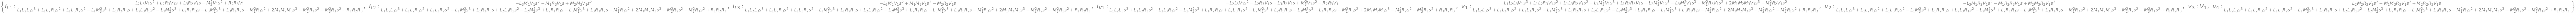

In [3]:
symbolic_solution = solve(equ,X)
symbolic_solution

In [4]:
left_side = list(symbolic_solution.keys())
right_side = list(symbolic_solution.values())

for i in range(len(symbolic_solution)):
    pprint(Eq(left_side[i],right_side[i]))

                                   3                2                2        
                      L₁⋅L₂⋅L₃⋅V₁⋅s  + L₁⋅L₂⋅R₃⋅V₁⋅s  + L₁⋅L₃⋅R₂⋅V₁⋅s  - L₁⋅M₃
v₁ = ─────────────────────────────────────────────────────────────────────────
               3             2             2        2  3                      
     L₁⋅L₂⋅L₃⋅s  + L₁⋅L₂⋅R₃⋅s  + L₁⋅L₃⋅R₂⋅s  - L₁⋅M₃ ⋅s  + L₁⋅R₂⋅R₃⋅s + L₂⋅L₃⋅

2     3                        2     3        2     3     2        2          
 ⋅V₁⋅s  + L₁⋅R₂⋅R₃⋅V₁⋅s - L₂⋅M₂ ⋅V₁⋅s  - L₃⋅M₁ ⋅V₁⋅s  - M₁ ⋅R₃⋅V₁⋅s  + 2⋅M₁⋅M₂
──────────────────────────────────────────────────────────────────────────────
    2        2  3                     2  3                  2     2           
R₁⋅s  - L₂⋅M₂ ⋅s  + L₂⋅R₁⋅R₃⋅s - L₃⋅M₁ ⋅s  + L₃⋅R₁⋅R₂⋅s - M₁ ⋅R₃⋅s  + 2⋅M₁⋅M₂⋅

        3     2        2                
⋅M₃⋅V₁⋅s  - M₂ ⋅R₂⋅V₁⋅s                 
────────────────────────────────────────
    3     2     2     2     2           
M₃⋅s  - M₂ ⋅R₂⋅s  - M₃ ⋅R₁⋅s  + R₁⋅R₂⋅R₃
   

The transfer function H(s)=V2(s)/V1

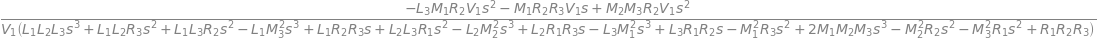

In [5]:
symbolic_solution[v2]/V1

## Numeric solution

In [6]:
# put the component values into dictionary format
K1, K2, K3 = symbols('K1 K2 K3') # initiate symbols for the inductor coupling coeff
component_values = {
    V1:1.0000e+01,
    L1:1.0000e+01,
    L2:2.0000e+01,
    L3:3.0000e+01,
    R2:5.0000e+00,
    R3:1.0000e+01,
    R1:2.0000e+00,
    K1:2.0000e-01,
    K2:8.0000e-01,
    K3:5.0000e-01}

From the LTSpice netlist:

>K1 L1 L2 0.2  
K2 L1 L3 0.8   
K3 L2 L3 0.5  

K1, K2 and K3 are the coefficient of coupling. These need to be converted to mutual inductance.

Need to solve for M1, M2 and M3:  
$M_1 = K1 \times {\sqrt{L_1 \times L_2}}$  
$M_2 = K2 \times {\sqrt{L_1 \times L_3}}$  
$M_3 = K3 \times {\sqrt{L_2 \times L_3}}$  

In [7]:
# calculate the coupling constant from the mutual inductance
component_values[M1] = component_values[K1]*np.sqrt(component_values[L1] *component_values[L2])
print('mutual inductance, M1 = {:.9f}'.format(component_values[M1]))

component_values[M2] = component_values[K2]*np.sqrt(component_values[L1] *component_values[L3])
print('mutual inductance, M2 = {:.9f}'.format(component_values[M2]))

component_values[M3] = component_values[K3]*np.sqrt(component_values[L2] *component_values[L3])
print('mutual inductance, M3 = {:.9f}'.format(component_values[M3]))

mutual inductance, M1 = 2.828427125
mutual inductance, M2 = 13.856406461
mutual inductance, M3 = 12.247448714


In [8]:
component_values

In [9]:
equ1a = equ.subs(component_values)
equ1a

⎡                       I_L1 + 0.5⋅v₁ - 0.5⋅v₃                        ⎤   ⎡ 0 
⎢                                                                     ⎥   ⎢   
⎢                           -I_L2 + 0.2⋅v₂                            ⎥   ⎢ 0 
⎢                                                                     ⎥   ⎢   
⎢                       I_V1 - 0.5⋅v₁ + 0.5⋅v₃                        ⎥   ⎢ 0 
⎢                                                                     ⎥   ⎢   
⎢                            I_L3 + 0.1⋅v₄                            ⎥   ⎢ 0 
⎢                                                                     ⎥ = ⎢   
⎢                                 v₃                                  ⎥   ⎢10.
⎢                                                                     ⎥   ⎢   
⎢-10.0⋅I_L1⋅s - 2.82842712474619⋅I_L2⋅s - 13.856406460551⋅I_L3⋅s + v₁ ⎥   ⎢ 0 
⎢                                                                     ⎥   ⎢   
⎢-2.82842712474619⋅I_L1⋅s - 20.0⋅I_L2⋅s - 12.2474487

The equations above are using the component values and the Laplace variable.

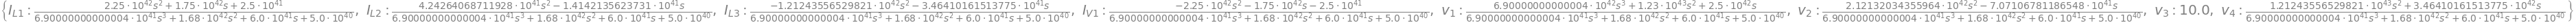

In [10]:
# solve the equations.
u1 = solve(equ1a,X)
u1 # the solution is too long to display correctly

The transfer function H(s)=V2(s)/V1

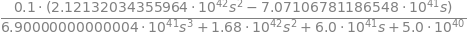

In [11]:
u1[v2]/component_values[V1]

## AC analysis
Solve equations for $\omega$ equal to 1 radian per second, s = 1j.

In [12]:
equ1a_1rad_per_s = equ1a.subs({s:1j})
equ1a_1rad_per_s  # display the equations

⎡                       I_L1 + 0.5⋅v₁ - 0.5⋅v₃                        ⎤   ⎡ 0 
⎢                                                                     ⎥   ⎢   
⎢                           -I_L2 + 0.2⋅v₂                            ⎥   ⎢ 0 
⎢                                                                     ⎥   ⎢   
⎢                       I_V1 - 0.5⋅v₁ + 0.5⋅v₃                        ⎥   ⎢ 0 
⎢                                                                     ⎥   ⎢   
⎢                            I_L3 + 0.1⋅v₄                            ⎥   ⎢ 0 
⎢                                                                     ⎥ = ⎢   
⎢                                 v₃                                  ⎥   ⎢10.
⎢                                                                     ⎥   ⎢   
⎢-10.0⋅ⅈ⋅I_L1 - 2.82842712474619⋅ⅈ⋅I_L2 - 13.856406460551⋅ⅈ⋅I_L3 + v₁ ⎥   ⎢ 0 
⎢                                                                     ⎥   ⎢   
⎢-2.82842712474619⋅ⅈ⋅I_L1 - 20.0⋅ⅈ⋅I_L2 - 12.2474487

In [13]:
ans1 = solve(equ1a_1rad_per_s,X)
ans1

In [14]:
for name, value in ans1.items():
    print('{:5s}: mag: {:10.6f} phase: {:11.5f} deg'.format(str(name),float(abs(value)),float(arg(value)*180/np.pi)))

v1   : mag:   8.002110 phase:    16.52297 deg
v2   : mag:   1.369735 phase:    15.27459 deg
v3   : mag:  10.000000 phase:     0.00000 deg
v4   : mag:   7.724137 phase:   -19.10576 deg
I_V1 : mag:   1.627911 phase:   135.65371 deg
I_L1 : mag:   1.627911 phase:   -44.34629 deg
I_L2 : mag:   0.273947 phase:    15.27459 deg
I_L3 : mag:   0.772414 phase:   160.89424 deg


The results from LTSpice AC analysis at 0.159 Hz are shown below.   
```
       --- AC Analysis ---

frequency:	0.159155	Hz
V(1):	mag:    8.00211 phase:     16.523° 	voltage
V(2):	mag:    1.36973 phase:    15.2746° 	voltage
V(4):	mag:    7.72414 phase:   -19.1058° 	voltage
V(3):	mag:         10 phase:          0° 	voltage
I(L1):	mag:    1.62791 phase:   -44.3463° 	device_current
I(L2):	mag:   0.273947 phase:    15.2746° 	device_current
I(L3):	mag:   0.772414 phase:    160.894° 	device_current
I(R2):	mag:   0.273947 phase:    15.2746° 	device_current
I(R3):	mag:   0.772414 phase:   -19.1058° 	device_current
I(R1):	mag:    1.62791 phase:    135.654° 	device_current
I(V1):	mag:    1.62791 phase:    135.654° 	device_current




--- AC Analysis ---

frequency:	0.159155	Hz
V(1):	mag:    8.00211 phase:     16.523° 	voltage
V(2):	mag:    1.36973 phase:    15.2746° 	voltage
V(4):	mag:    7.72414 phase:   -19.1058° 	voltage
V(3):	mag:         10 phase:          0° 	voltage
I(L1):	mag:    1.62791 phase:   -44.3463° 	device_current
I(L2):	mag:   0.273947 phase:    15.2746° 	device_current
I(L3):	mag:   0.772414 phase:    160.894° 	device_current
I(R2):	mag:   0.273947 phase:    15.2746° 	device_current
I(R3):	mag:   0.772414 phase:   -19.1058° 	device_current
I(R1):	mag:    1.62791 phase:    135.654° 	device_current
I(V1):	mag:    1.62791 phase:    135.654° 	device_current

```
~~There are some small numeric differences in some node voltages and phases.~~

## AC Sweep
Looking at node 2 voltage and comparing the results with those obtained from LTSpice. The frequency sweep is from 0.01 Hz to 10 Hz.

Load the csv file of node 2 voltage over the sweep range and plot along with the results obtained from SymPy.

In [15]:
os.chdir('/home/jeff32/Documents/Solving Electrical Engineering Problems with Python Blog/MNA Test Circuits/test_11/') # change directory to net list location

fn = 'test_11.csv' # data from LTSpice
LTSpice_data = np.genfromtxt(fn, delimiter=',')

# change the working director back to the Jupyter folder
os.chdir('/home/jeff32/Documents/JupyterLab/Node Analysis/')  

In [16]:
# initaliaze some empty arrays
frequency = np.zeros(len(LTSpice_data))
voltage = np.zeros(len(LTSpice_data)).astype(complex)

# convert the csv data to complez numbers and store in the array
for i in range(len(LTSpice_data)):
    frequency[i] = LTSpice_data[i][0]
    voltage[i] = LTSpice_data[i][1] + LTSpice_data[i][2]*1j

Load the Laplace polyinominal for node 2

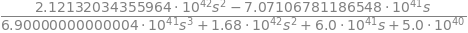

In [17]:
H = u1[v2]
H

In [18]:
num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)
system_c1 = (a, b) # system for circuit 1

In [19]:
x = np.linspace(0.01*2*np.pi, 10*2*np.pi, 10000, endpoint=True)
w_c1, mag_c1, phase_c1 = signal.bode(system_c1, w=x) # returns: rad/s, mag in dB, phase in deg

Plot the results.  
Using

> np.unwrap(2 * phase) / 2) 

to keep the pahse plots the same.

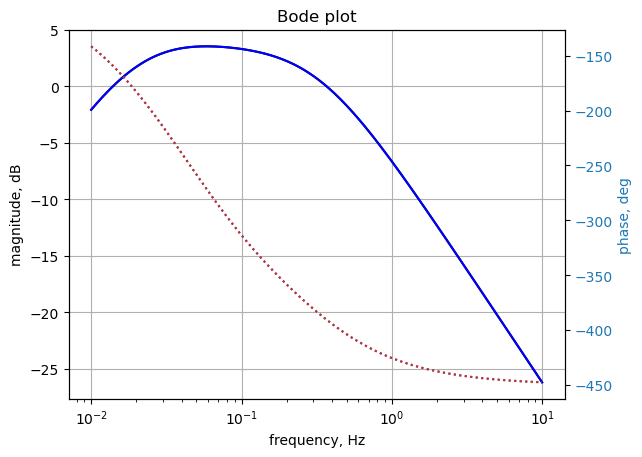

In [20]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(frequency, 20*np.log10(np.abs(voltage)),'-k')    # Bode magnitude plot
plt.semilogx(w_c1/(2*np.pi), mag_c1,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

#plt.semilogx(frequency, np.angle(voltage)*180/np.pi,':',color=color)  # Bode phase plot
plt.semilogx(frequency, np.unwrap(2*np.angle(voltage)/2) *180/np.pi,':',color=color)  # Bode phase plot
plt.semilogx(w_c1/(2*np.pi), phase_c1,':',color='tab:red')  # Bode phase plot


ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Bode plot')
plt.show()

The SymPy and LTSpice results overlay each other. 